# Averaging and Smoothing

The first type of model we will investigate uses some kind of average of the value at previous time steps to predict the next time step.

## What we will accomplish

In this notebook we will:
- Introduce the concept behind averaging or smoothing,
- Define a moving average model,
- Build upon that with a weighted average model,
- Learn about simple exponential smoothing,
- Extend that to double exponential smoothing and
- End with triple exponential smoothing or the Holt Winters model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

## What is an averaging/smoothing forecast

An averaging or smoothing forecast is one in which we take an average of some collection of previous values to predict the future value.

### Moving average forecast

For example,

$$
y_{t+1} = \frac{1}{3}\left(y_t + y_{t-1} + y_{t-2} \right) + \epsilon_t
$$

is a moving averaging forecast. Specifically this is known as a <i>moving average forecast</i> because you shift the points over which you average as $t$ increases.

The moving average forecast with window size $q$ and equal weights is:

$$
y_{t+1} = \left\lbrace \begin{array}{l c c} \frac{1}{q} \sum_{i=0}^{q-1} y_{t-i} + \epsilon_t & \text{for} & t \leq n-1 \\
\frac{1}{q} \sum_{i=0}^{q-1} y_{n-i} + \epsilon_t & \text{for} & t \geq n \end{array} \right\rbrace
$$

We can implement this on the Google stock data.

In [2]:
goog = pd.read_csv("../../../data/google_stock.csv", parse_dates=['date'])

In [3]:
goog_train = goog.iloc[:-14].copy()
goog_test = goog.iloc[-14:].copy()

`pandas` has nice functionality for computing moving averages called `rolling`, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html">https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html</a>.

In [4]:
## To use rolling
## specify the column you want the moving average of
## give the window size as the argument
## then give what you want the moving statistic of, we want the mean()
## Finally set the argument closed='left' to ensure that y_{t+1} is the average
## of the previous k values.
pd.DataFrame({'closing_price':goog_train.closing_price,
                  'moving_avg':goog_train.closing_price.rolling(3,
                                                                closed='left').mean()})

,closing_price,moving_avg
0,49.982655,NaN
1,53.952770,NaN
2,54.495735,NaN
3,52.239197,52.810387
4,52.802086,53.562567
...,...,...
4413,2683.360107,2680.559977
4414,2695.030029,2690.523356
4415,2686.159912,2692.070068
4416,2642.439941,2688.183349


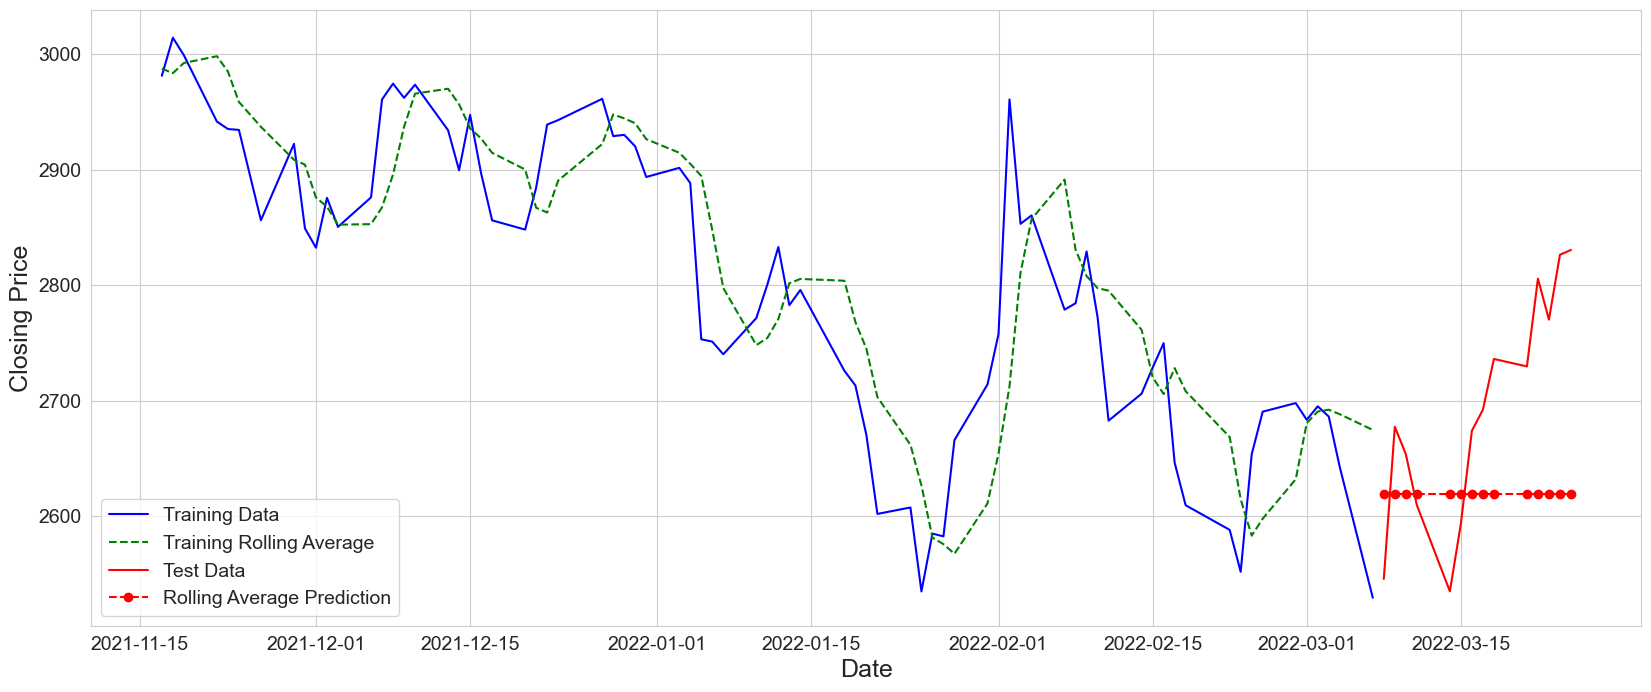

In [5]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")

plt.plot(goog_train.date[-75:], 
         goog_train.closing_price.rolling(3, closed="left").mean()[-75:],
         'g--',
         label="Training Rolling Average")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

plt.plot(goog_test.date, 
         goog_train.closing_price[-3:].mean()*np.ones(14),
         'r--o',
         label="Rolling Average Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

As you may have noticed, the moving average tends to lag behind the actual data. This is a weakness of the model.

Moving averages can be used for more than just making forecasts. We can also use them to look for trends or patterns in the data set. This can be accomplished by changing the window size.

For example, below as we increase the window size we start to reveal the increasing trend of the data set. While we could have identified this trend without the moving average, there are some noisier data sets in which patterns are more difficult to identify and the moving average can help us find hard to see seasonality or trends.

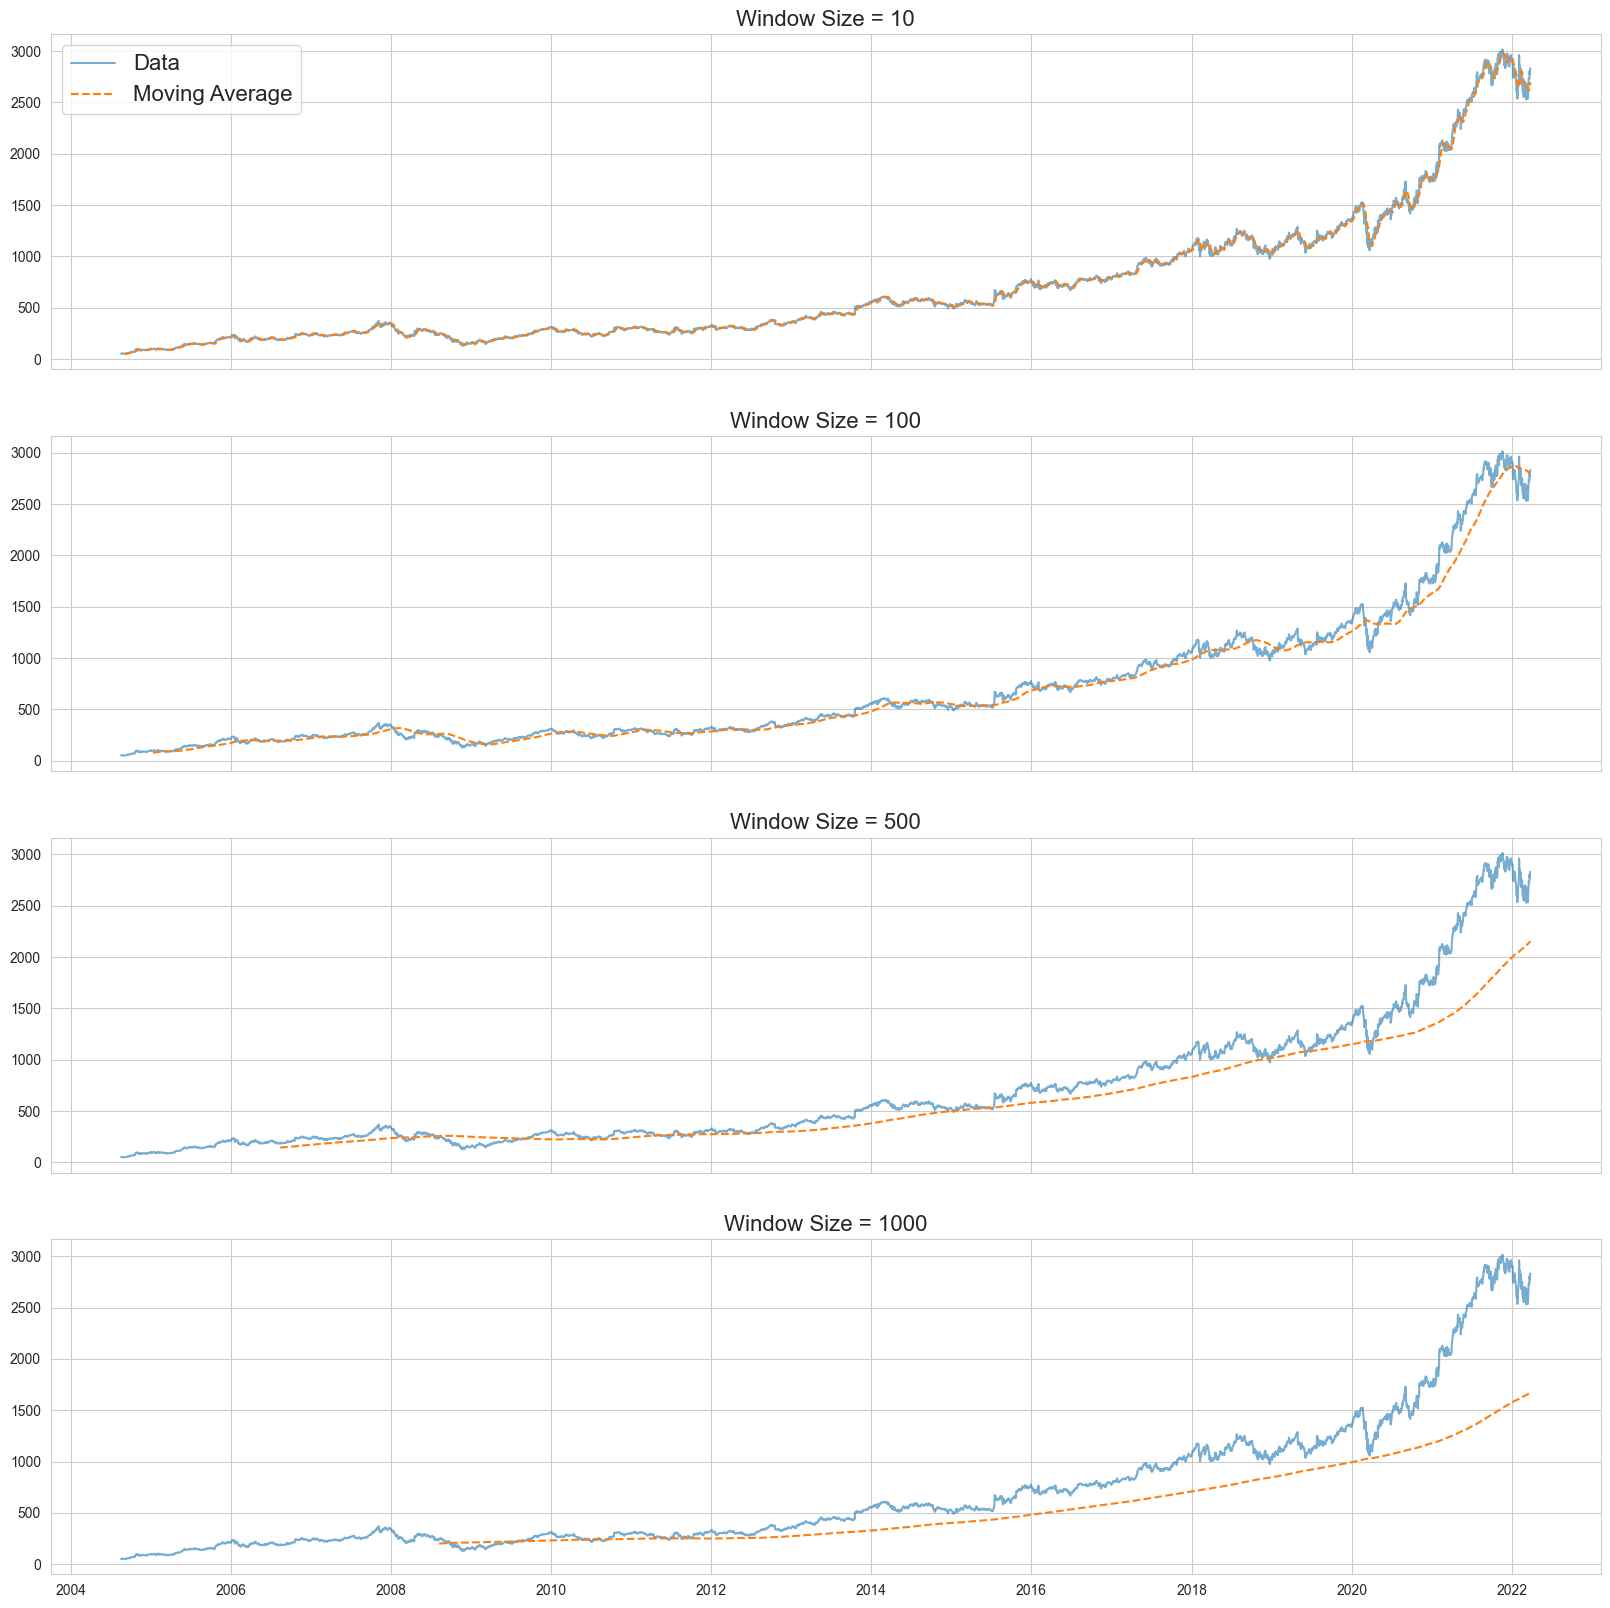

In [6]:
fig,ax = plt.subplots(4, 1, figsize=(20,20), sharex=True, sharey=True)

ax[0].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[0].plot(goog.date, 
           goog.closing_price.rolling(10, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Moving Average")

ax[0].legend(fontsize=16)
ax[0].set_title("Window Size = 10", fontsize=16)

ax[1].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[1].plot(goog.date, 
           goog.closing_price.rolling(100, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Moving Average")
ax[1].set_title("Window Size = 100", fontsize=16)


ax[2].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[2].plot(goog.date, 
           goog.closing_price.rolling(500, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Moving Average")
ax[2].set_title("Window Size = 500", fontsize=16)


ax[3].plot(goog.date, 
           goog.closing_price,
           alpha=.6,
           label="Data")
ax[3].plot(goog.date, 
           goog.closing_price.rolling(1000, closed='left').mean(),
           '--',
           linewidth=1.5,
           label="Moving Average")
ax[3].set_title("Window Size = 1000", fontsize=16)




# plt.xlabel("Date", fontsize=18)
# plt.ylabel("Closing Price", fontsize=18)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

plt.show()

### More general weighted average forecasts

To this point we have only considered average forecasts in which each previous time point considered has been given equal weight. You can more generally apply disproportionate weighting, for example if you wanted to give more weight to the recent observations.

As an example we will visualize the following weighted moving average forecast on the Google data:

$$
y_{t} = \left\lbrace \begin{array}{l c c} \frac{2}{3}y_{t-1} + \frac{1}{6}y_{t-2} + \frac{1}{6} y_{t-3} + \epsilon_t & \text{for} & t \leq n-1 \\
\frac{2}{3}y_{n-1} + \frac{1}{6}y_{n-2} + \frac{1}{6} y_{n-3} + \epsilon_t & \text{for} & t \geq n \end{array} \right\rbrace
$$

In [7]:
def weight_avg(t):
    return (2/3)*goog_train.closing_price.values[t-1] + (1/6)*goog_train.closing_price.values[t-2] + (1/6)*goog_train.closing_price.values[t-3]

goog_train_fit = []

for i in range(3,len(goog_train)):
    goog_train_fit.append(weight_avg(i))
        
        
pred = weight_avg(len(goog_train))

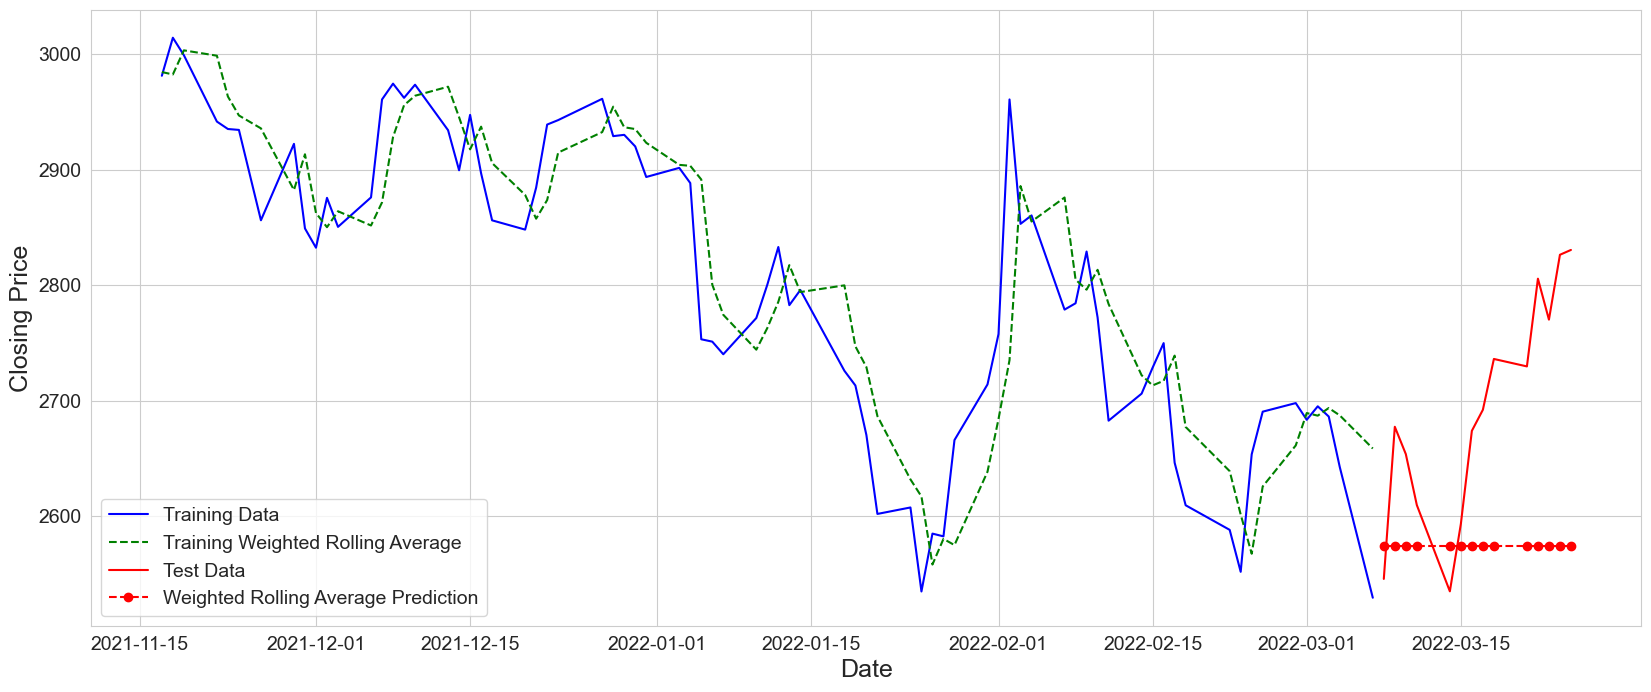

In [8]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")



plt.plot(goog_train.date[-75:], 
         goog_train_fit[-75:],
         'g--',
         label="Training Weighted Rolling Average")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

plt.plot(goog_test.date, 
         pred*np.ones(14),
         'r--o',
         label="Weighted Rolling Average Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

#### Underlying model

An underlying statistical model for these types of forecasts can be established. Let $\left\lbrace \epsilon_t \right\rbrace$ be a white noise sequence. Then a moving average stochastic process of order $q$ (MA($q$)) is given by: $y_t = \beta_0 \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_q \epsilon_{t-q}$.

## Exponential smoothing

We will introduce three exponential smoothing forecasts.

In order to define these forecasts it is useful to reintroduce the <i>hat</i> notation we have used in the past. Let $\hat{y}_t$ denote the forecast according to the model at time $t$.

### Simple exponential smoothing

First we will define simple exponential smoothing:

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c}\alpha y_{t-1} + (1-\alpha) \hat{y}_{t-1} & \text{for} & t\leq n \\
                                               \alpha y_n + (1-\alpha) \hat{y}_n & \text{for} & t > n \end{array}\right\rbrace, 
$$

where $\alpha \in [0,1]$ is a hyperparameter that you can select by hand or through some kind of algorithm.

There are two ways that it may be helpful to think about this model.

##### 1. An adjustment of the naive forecast

With a little rearrangement you can turn simple exponential smoothing into:

$$
\hat{y}_{t+1} = \hat{y}_t + \alpha \left( y_t - \hat{y}_t \right) = \hat{y}_t + \alpha e_t,
$$

where we can think of $e_t$ as an "error" term.

##### 2. A weighted average that we can "optimize"

When it is written out all the way the simple exponential smoothing is:

$$
\hat{y}_{t+1} = \alpha \left[y_t +(1-\alpha) y_{t-1} + (1-\alpha)^2 y_{t-2} + \dots + (1-\alpha)^{t-1} y_1\right].
$$

This is a weighted sum including all prior information for which we can find the "optimal" value of $\alpha$, where here "optimal" may mean different things depending on your end goal.

By contrast, if we attempted to find unique weights for each time step finding the ones that provide the "best" model for our data may be difficult.

#### Simple exponential smoothing in python

We can implement the simple exponential smoothing model in python with the `statsmodels` package, <a href="https://www.statsmodels.org/stable/index.html">https://www.statsmodels.org/stable/index.html</a>. First we will check that we have this package installed.

In [9]:
## Importing statsmodels to check that we have it installed
import statsmodels as sm

In [10]:
## printing the statsmodels version
## I had version 0.13.5 when I wrote this notebook
print(sm.__version__)

0.13.5


If needed, installation instructions for pip and conda can be found here <a href="https://www.statsmodels.org/stable/install.html">https://www.statsmodels.org/stable/install.html</a>.

Simple exponential smoothing can be implemented with the `SimpleExpSmoothing` model type in `statsmodels`, <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing">https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing</a>.

In [11]:
## Importing the model from statsmodels
from statsmodels.tsa.api import SimpleExpSmoothing

In [12]:
## To fit a SimpleExpSmoothing model you
## First call SimpleExpSmoothing with the training data
## then .fit
## with smoothing_level, this is alpha
## and optimized=False, if this is True alpha is found using the method of maximum likelihood
simp_exp_smooth = SimpleExpSmoothing(goog_train.closing_price.values).fit(smoothing_level=.6,
                                                                             optimized=False)

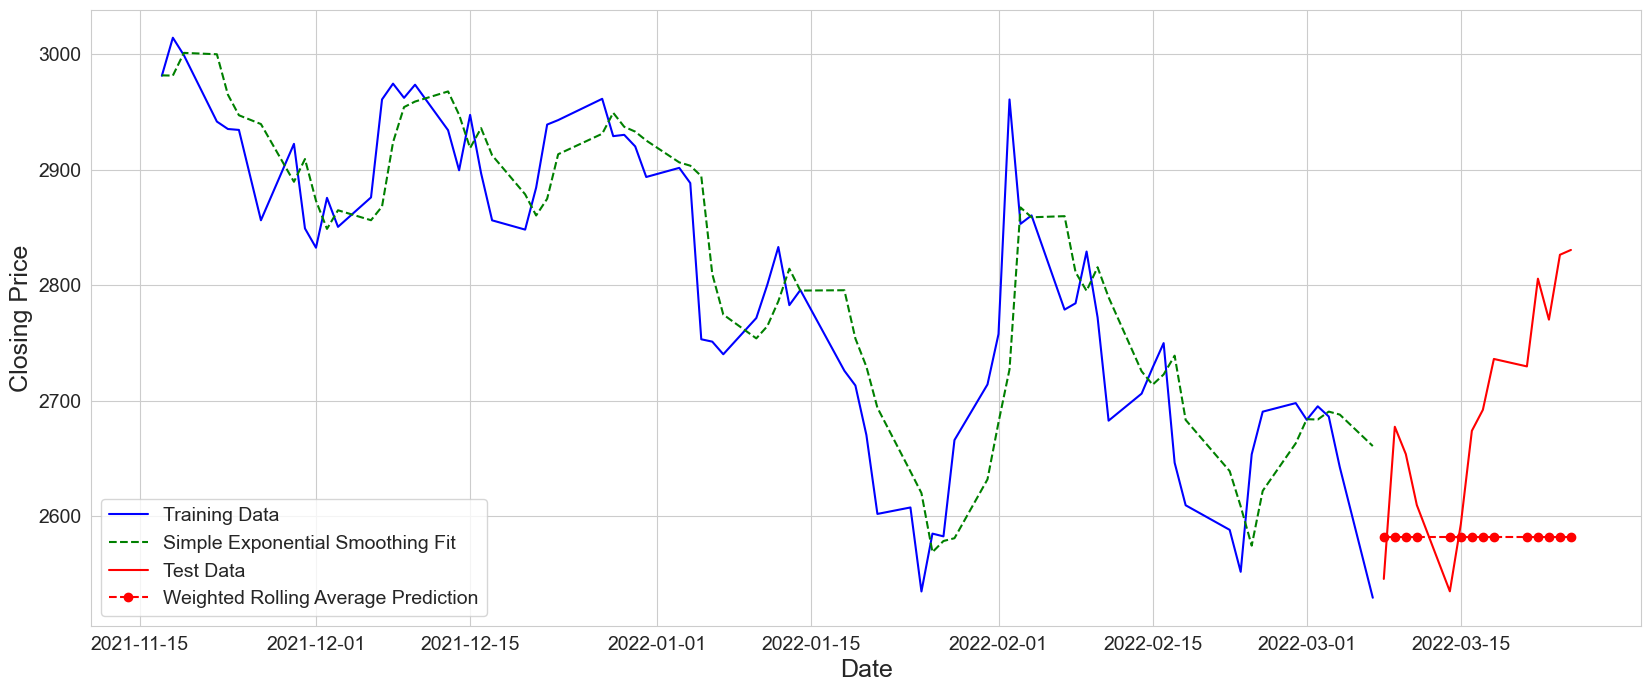

In [13]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(goog_train.date[-75:], 
         simp_exp_smooth.fittedvalues[-75:],
         'g--',
         label="Simple Exponential Smoothing Fit")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

## We can get the forecast with .forecast(h)
plt.plot(goog_test.date, 
         simp_exp_smooth.forecast(14),
         'r--o',
         label="Weighted Rolling Average Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Here we could use cross-validation or a validation set to find the "best" $\alpha$.

#### Underlying model

An underlying model for the time series that would be appropriate for simple exponential smoothing can be described. Let $\left\lbrace \epsilon_t \right\rbrace$ be a white noise sequence. Then the model is given by $y_t = \mu + \alpha \sum_{j<t} \epsilon_j + \epsilon_t$ for $\mu \in \mathbb{R}$ and $\alpha \in [0,1]$. 

### Double exponential smoothing

Simple exponential smoothing does not deal well with time series that exhibit a trend. An expansion built to handle trends is <i>double exponential smoothing</i>. This model is "double" exponential smoothing because we literally do two times the exponential smoothing as simple exponential smoothing:


$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} s_{t-1} + b_{t-1} & \text{for} & 1<t\leq n \\
                                                s_n + (t-n)b_{n}& \text{for} & t > n \end{array}\right\rbrace, 
$$

where 

$$
s_{t+1} = \alpha y_t + (1-\alpha) (s_{t-1} + b_{t-1}), \ s_1 = y_1, 
$$

$$
b_{t+1} = \beta (s_t - s_{t-1}) + (1-\beta) b_{t-1}, \ b_1 = y_2 - y_1 \text{ and}
$$

$\alpha \in [0,1]$ and $\beta \in [0,1]$ are hyperparameters that we can select by hand or though an optimization process.

The first exponential smoothing is applied much like simple exponential smoothing to the observed values of the time series and the second exponential smoothing is applied to the "trend" which is approximated with a series of first differences ($y_{t} - y_{t-1}$ or $s_t - s_{t-1}$).

#### Double exponential smoothing in python

We can implement this in python with `statsmodel`'s `Holt` model object, <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.Holt.html">https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.Holt.html</a>.

In [14]:
from statsmodels.tsa.holtwinters import Holt

In [15]:
## Here in addition to setting a smoothing_level
## we also set a smoothing_trend, which is the value of beta
## again we set optimized = False, unless we'd rather choose alpha and beta through
## maximum likelihood estimation
exp_smooth = Holt(goog_train.closing_price.values).fit(smoothing_level=0.1, 
                                                          smoothing_trend=0.1,
                                                          optimized=False)

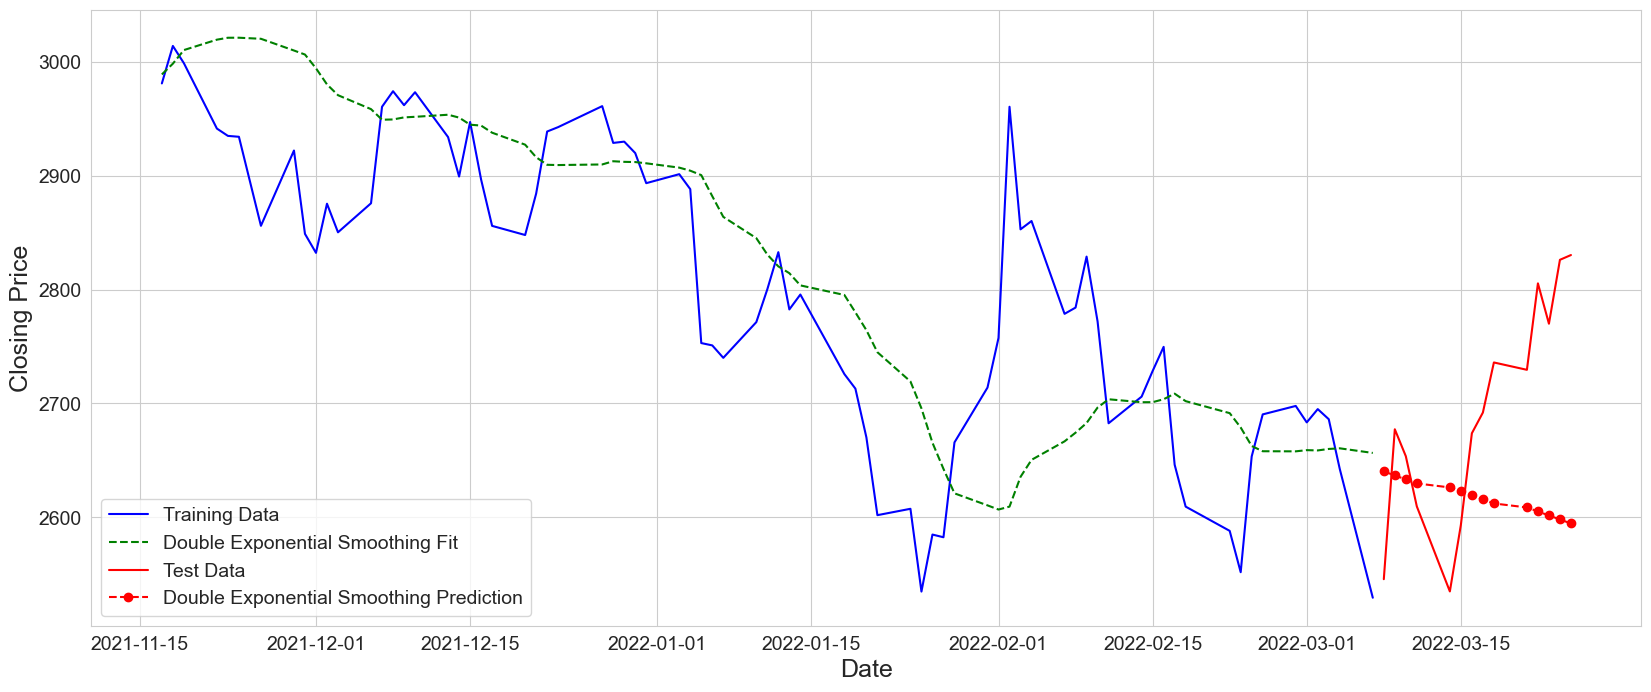

In [16]:
plt.figure(figsize=(20,8))


plt.plot(goog_train.date[-75:], 
         goog_train.closing_price[-75:],
         'b',
         label="Training Data")


## We can get the fitted values with fittedvalues
plt.plot(goog_train.date[-75:], 
         exp_smooth.fittedvalues[-75:],
         'g--',
         label="Double Exponential Smoothing Fit")

plt.plot(goog_test.date, 
         goog_test.closing_price,
         'r',
         label="Test Data")

## We can get the forecast with .forecast(h)
plt.plot(goog_test.date, 
         exp_smooth.forecast(14),
         'r--o',
         label="Double Exponential Smoothing Prediction")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

<i>Note: The observations may look like not a straight line, but that is because we do not trade stocks on the weekend</i>

As we can see from this example, that depending on the value of $\beta$ double exponential smoothing may pay too much attention to a recent trend. Again you can play around with finding the optimal $\alpha$ and $\beta$ with cross-validation or a validation set.

### Triple exponential smoothing or the Holt-Winters forecast

The final forecast we will look at in this notebook is <i>triple exponential smoothing</i> or the <i>Holt-Winters</i> model. Holt-Winters adds a third smoothing component to account for seasonal trends in time series. The third component can take one of two forms because there can be different kinds of seasonality present in a time series.

#### 1. Multiplicative version

The first of these is thought of as <i>multiplicative seasonality</i>. 

Multiplicative seasonality occurs when the value of the next time step in the cycle is some <i>multiple</i> of the previous time step. For example, in infectious disease spread there is the concept of $R_0$, which is the number of individuals an infectious person is expected to infect in a completely susceptible population. So early in the stages of infectious disease spread, we may reasonably assume that the number of new cases in the next time step is roughly $R_0$ times the number of new cases in this time step (assuming that, again, we are early in the disease spreading process and the time step roughly corresponds with the infectious period of the disease and a lot of other assumptions that infectious disease modelers make).

The multiplicative version of the Holt-Winters model is:

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} \left( s_{t-1} + b_{t-1} \right) c_{t-m} & \text{for} & 1<t\leq n \\
                                                \left( s_n + (t-n)b_n \right)c_{n-m+1 + (t-n-1)\%m} & \text{for} & t > n \end{array}\right\rbrace, 
$$

where

$$
s_{t+1} = \alpha \frac{y_t}{c_{t-m}} + \left(1-\alpha\right) \left( s_{t-1} + b_{t-1}\right), \ s_1 = y_1,
$$

$$
b_{t+1} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}, \ b_1 = y_2 - y_1,
$$

$$
c_{t+1} = \gamma \frac{y_t}{s_t} + (1-\gamma)c_{t-m},
$$

$\%$ denotes modular division, $m$ is the number of time steps that make up a season and $\alpha \in [0,1]$, $\beta \in [0,1]$ and $\gamma \in [0,1]$ are all hyperparameters.

#### 2. Additive version

The second form of seasonality is thought of as <i>additive seasonality</i>.

Additive seasonality is when the value at the subsequent time step in the cycle is some amount added to the previous step. For example, maybe an ice cream shop consistently sees $\$ 100$ more in sales from Q3 to Q4, due to say a typical increase in temperature.

The additive Holt-Winters model is:

$$
\hat{y}_{t} = \left\lbrace \begin{array}{l c c} s_{t-1} + b_{t-1} + c_{t-m} & \text{for} & 1<t\leq n \\
                                                s_n + (t-n)b_n  + c_{n-m+1 + (t-n-1)\%m} & \text{for} & t > n \end{array}\right\rbrace, 
$$

where

$$
s_{t+1} = \alpha (y_t - c_{t-m}) + \left(1-\alpha\right) \left( s_{t-1} + b_{t-1}\right), \ s_1 = y_1,
$$

$$
b_{t+1} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}, \ b_1 = y_2 - y_1,
$$

$$
c_{t+1} = \gamma (y_t - s_{t-1} - b_{t-1}) + (1-\gamma)c_{t-m},
$$

$\%$ denotes modular division, $m$ is the number of time steps that make up a season and $\alpha$, $\beta$ and $\gamma$ are all hyperparameters.

#### Implementing in python

You can implement either version of the Holt-Winters model in python using `statsmodels` `ExponentialSmoothing` model, <a href="https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html">https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html</a>.

In [17]:
from statsmodels.tsa.api import ExponentialSmoothing

To test this model out we will return to our flu data set.

In [18]:
flu = pd.read_csv("../../../data/us_flu_1928_1948.csv", parse_dates=['date'])

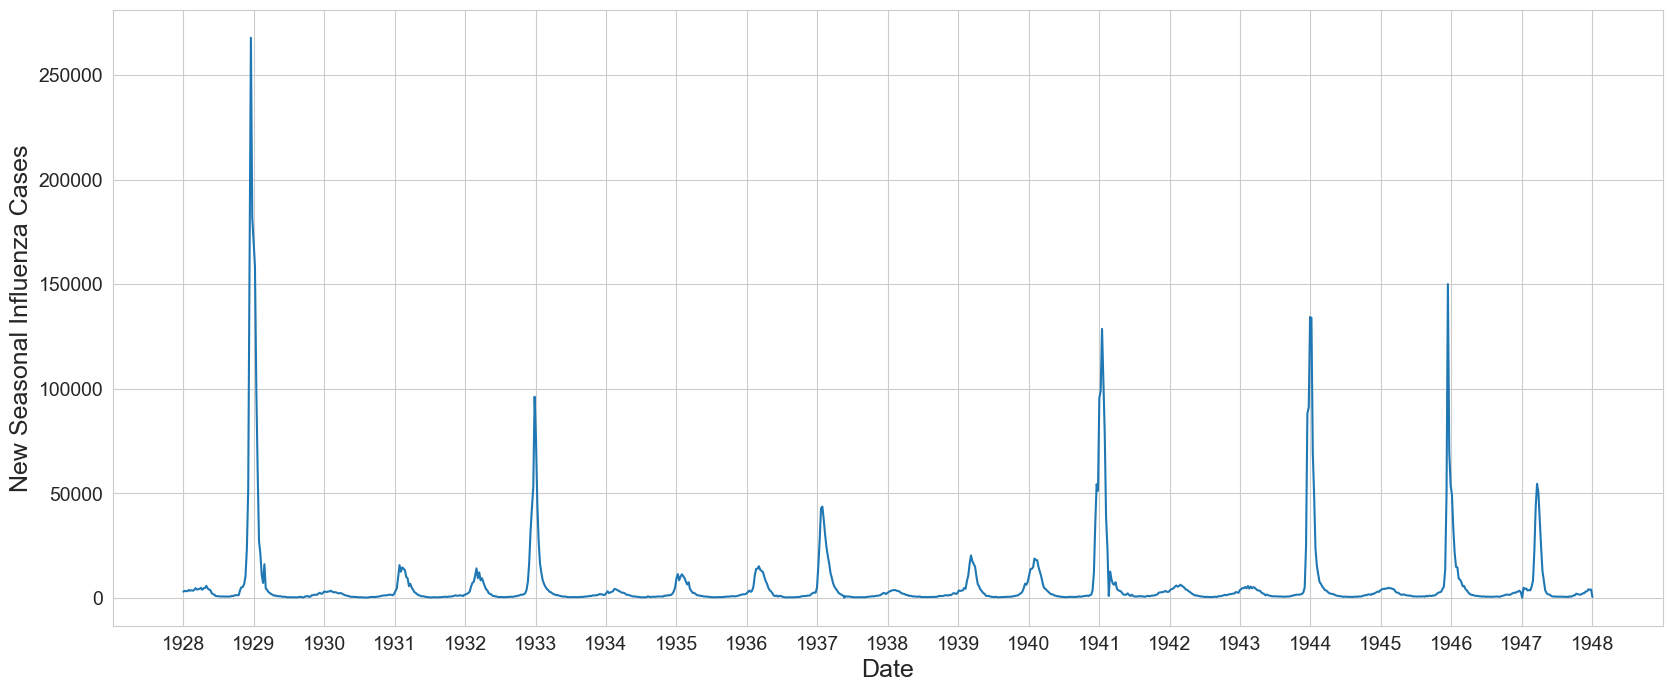

In [19]:
plt.figure(figsize=(20,8))

plt.plot(flu.date, flu.cases)

plt.xlabel("Date", fontsize=18)
plt.ylabel("New Seasonal Influenza Cases", fontsize=18)

plt.xticks([datetime(1928,1,1) + timedelta(days=365*i) for i in range(21)],
           [str(i) for i in range(1928, 1949)],
           fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [20]:
flu_train = flu.loc[flu.year < 1947].copy()
flu_test = flu.loc[flu.year == 1947].copy()

For these data we will use the mutliplicative model.

In [21]:
## Call ExponentialSmoothing
## input the training data
## set seasonal = "mul", for additive you would set it equal to "add"
## You set m using seasonal_periods = 
## Then call fit
## set a smoothing_level, alpha
## set a smoothing_trend, beta
## set a smoothing_seasonal, gamma
## Set optimized = False, unless you want maximum likelihood to estimate alpha, beta, gamma
holt_winter = ExponentialSmoothing(flu_train.cases.values,
                                      seasonal='mul',
                                      seasonal_periods=52).fit(smoothing_level=0,
                                                                  smoothing_trend=0,
                                                                  smoothing_seasonal=.8,
                                                                  optimized=False)

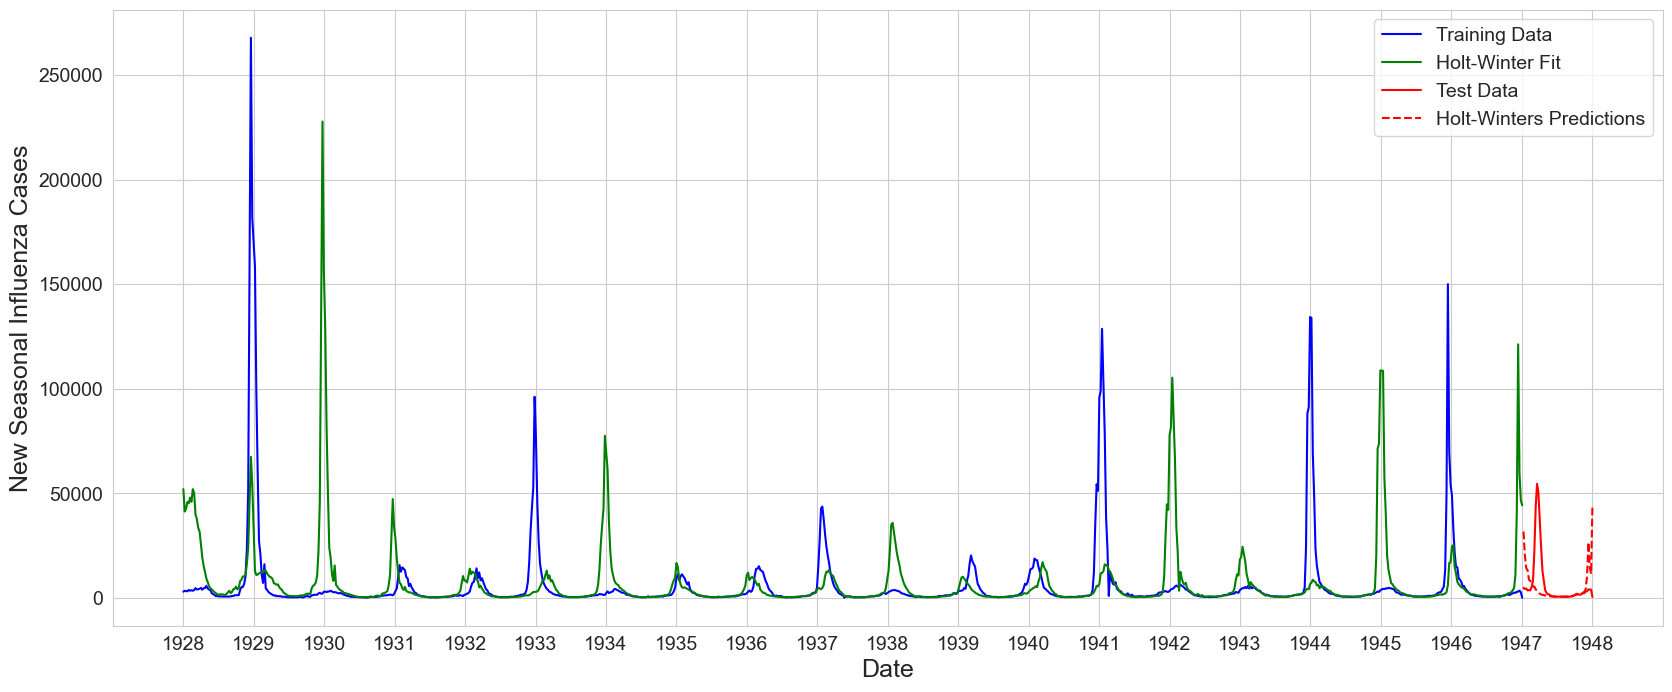

In [22]:
plt.figure(figsize=(20,8))




plt.plot(flu_train.date, 
         flu_train.cases,
         'b-',
         label="Training Data")
plt.plot(flu_train.date, 
         holt_winter.fittedvalues, 
         'g-',
         label="Holt-Winter Fit")

plt.plot(flu_test.date, 
         flu_test.cases,
         'r-',
         label="Test Data")

plt.plot(flu_test.date, 
         holt_winter.forecast(52),
         'r--',
         label="Holt-Winters Predictions")


plt.xlabel("Date", fontsize=18)
plt.ylabel("New Seasonal Influenza Cases", fontsize=18)

plt.xticks([datetime(1928,1,1) + timedelta(days=365*i) for i in range(21)],
           [str(i) for i in range(1928, 1949)],
           fontsize=14)
         
plt.yticks(fontsize=14)
         
plt.legend(fontsize=14)

plt.show()

As we have said before we can use cross-validation or a validation set to find the "best" values for our hyperparameters.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)